In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/offensive/malayalam

/content/drive/MyDrive/offensive/malayalam


In [ ]:
ls

l10c02_nlp_multiple_models_for_predicting_sentiment.ipynb
mal_full_offensive_dev.csv
mal_full_offensive_test.csv
mal_full_offensive_train.csv
offensive_malayalam.ipynb


In [ ]:
import pandas as pd
import re
import numpy as np
import itertools
import collections
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud

import nltk
nltk.download('treebank')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

import gensim
from gensim.models import KeyedVectors, Word2Vec, FastText

import tensorflow as tf

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
train_df = pd.read_csv("mal_full_offensive_train.csv", header=None, sep='\t')
train_df.head()

,0,1,2
0,പലദേശം. പല ഭാഷ ഒരേ ഒരു രാജാവ് അല്ലാതെ സ്വന്ത...,Not_offensive,NaN
1,ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവ...,Not_offensive,NaN
2,ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്...,Not_offensive,NaN
3,Sushin syam Shaiju khalid Midhun manual,Not_offensive,NaN
4,J A K E S. B EJ O Y !!!,Not_offensive,NaN


In [ ]:
valid_df = pd.read_csv("mal_full_offensive_dev.csv", header=None, sep='\t')
valid_df.head()

,0,1,2
0,Gopichettante BGM um mammookayum ishtapedunnav...,Not_offensive,NaN
1,ഇത് ഒരു പെണ്ണ് തന്നെ ആണോ direct ചെയ്യുന്നത് p...,Not_offensive,NaN
2,പൃഥ്വിരാജ് സുരാജേട്ടൻ ലാലും അലക്സ്.. Lal jr. ന...,Not_offensive,NaN
3,പോകരുത് മക്കളെ പോക്ക .......... നൻ കണ്ട് എന്റ്...,Not_offensive,NaN
4,avan Varum ente Makan Madhura Raja....,Not_offensive,NaN


In [ ]:
test_df = pd.read_csv("mal_full_offensive_test.csv", header=None, sep='\t')
test_df.head()

,0
0,അപ്പൊ ഇതൊരൊന്നൊരാ മൊതലാണല്ലേ Suraj ആണ് നടൻ ന്...
1,എന്ത് ഊള എഡിറ്റിംഗ് ആടോ ഇത് ഒരുമാതിരി vivo vid...
2,Fefka ee padam release cheyyan samadhicho?
3,അആഹാ.. സംഗീതം ജെക്‌സ് ബിജോയ് ആണ് അപ്പൊ പൊട്ടലു...
4,Ravile thane views likes ethra ayyi enn nokan ...


In [ ]:
def preprocess_data(text):
  user_name = '@[A-Za-z0-9]+' # Pattern for matching the user names in the tweet
  has_tag = '#[A-Za-z0-9]+' # Pattern for matching the hasgtags in the tweer
  url = 'https?:\/\/[A-Za-z0-9\.\/\-]+' # Pattern for matching the URLs in the tweet
  
  x = text.lower()  # Lower casing all the characters
  x = re.sub(user_name, '', x) # Replace the username with an empty characrer
  x = re.sub(has_tag,'',x) # Replace the hashtags with an empty characrer
  x = re.sub(url, '', x) # Replace the URLs with an empty characrer
  x = x.translate(str.maketrans('', '', string.punctuation)) # Replace all the characters except alphabets and digits from the tweet

  return x

In [ ]:
train_df[0] = train_df[0].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
valid_df[0] = valid_df[0].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
test_df[0] = test_df[0].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe

In [ ]:
print(train_df.head())
print()
print(valid_df.head())
print()
print(test_df.head())

                                                   0              1   2
0  പലദേശം പല ഭാഷ ഒരേ ഒരു രാജാവ്  അല്ലാതെ  സ്വന്തം...  Not_offensive NaN
1  ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവ...  Not_offensive NaN
2  ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്...  Not_offensive NaN
3          sushin syam  shaiju khalid  midhun manual  Not_offensive NaN
4                              j a k e s   b ej o y   Not_offensive NaN

                                                   0              1   2
0  gopichettante bgm um mammookayum ishtapedunnav...  Not_offensive NaN
1  ഇത് ഒരു പെണ്ണ് തന്നെ ആണോ direct ചെയ്യുന്നത്  p...  Not_offensive NaN
2  പൃഥ്വിരാജ് സുരാജേട്ടൻ ലാലും അലക്സ് lal jr ന്റെ...  Not_offensive NaN
3  പോകരുത് മക്കളെ പോക്ക  നൻ കണ്ട് എന്റ്യെ അമ്മോ പ...  Not_offensive NaN
4                 avan varum ente makan madhura raja  Not_offensive NaN

                                                   0
0  അപ്പൊ ഇതൊരൊന്നൊരാ മൊതലാണല്ലേ  suraj ആണ് നടൻ ന്...
1  എന്ത് ഊള എഡിറ്റിംഗ് ആടോ ഇ

In [ ]:
train_text = train_df[0].tolist()
valid_text = valid_df[0].tolist()
test_text = test_df[0].tolist()

train_label = train_df[1].tolist()
valid_label = valid_df[1].tolist()

In [ ]:
class_names = list(set(train_label))
class_names

['not-malayalam',
 'Offensive_Untargetede',
 'Offensive_Targeted_Insult_Group',
 'Offensive_Targeted_Insult_Individual',
 'Not_offensive']

In [ ]:
class_dist = Counter(train_label)
class_dist

Counter({'Not_offensive': 14153,
         'Offensive_Targeted_Insult_Group': 140,
         'Offensive_Targeted_Insult_Individual': 239,
         'Offensive_Untargetede': 191,
         'not-malayalam': 1287})

In [ ]:
le = LabelEncoder()

train_label = le.fit_transform(train_label)
valid_label = le.fit_transform(valid_label)

In [ ]:
le.inverse_transform([0,1,2,3,4])

array(['Not_offensive', 'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual', 'Offensive_Untargetede',
       'not-malayalam'], dtype='<U36')

In [ ]:
class_weight = {0:sum(class_dist.values())/class_dist[le.inverse_transform([0])[0]],
                1:sum(class_dist.values())/class_dist[le.inverse_transform([1])[0]],
                2:sum(class_dist.values())/class_dist[le.inverse_transform([2])[0]],
                3:sum(class_dist.values())/class_dist[le.inverse_transform([3])[0]],
                4:sum(class_dist.values())/class_dist[le.inverse_transform([4])[0]]}

class_weight

{0: 1.1312089309686992,
 1: 114.35714285714286,
 2: 66.98744769874477,
 3: 83.82198952879581,
 4: 12.439782439782439}

In [ ]:
training_labels = tf.keras.utils.to_categorical(train_label)
validation_labels = tf.keras.utils.to_categorical(valid_label)

In [ ]:
words_in_train = [sent.split() for sent in train_text] # Splitting the tweet into tokens
words_in_train[0:5]

[['പലദേശം',
  'പല',
  'ഭാഷ',
  'ഒരേ',
  'ഒരു',
  'രാജാവ്',
  'അല്ലാതെ',
  'സ്വന്തം',
  'രാജവയത്',
  'അല്ല'],
 ['ഈ',
  'ഓണം',
  'ഏട്ടനും',
  'പിള്ളേർക്ക്',
  'ഉള്ളതാണ്',
  'എന്ന്',
  'ഉള്ളവർ',
  'ലൈക്\u200c',
  'അടി'],
 ['ആരണ്ട',
  'ആരണ്ട',
  'തലുണ്ടാകാണാ',
  'ആരണ്ട',
  'ഞാൻ',
  'ആണ്ട',
  'ഞാൻ',
  'ആണ്ട',
  'ഞാൻ',
  'royal',
  'mech',
  'ആടാ',
  'ആരണ്ട',
  'ആരണ്ട',
  'മീശ',
  'പിരിക്കുന്ന',
  'ആരണ്ട',
  'ഞാൻ',
  'ആണ്ട',
  'ഞാൻ',
  'ആണ്ട',
  'ഞാൻ',
  'royal',
  'mech',
  'ആടാ'],
 ['sushin', 'syam', 'shaiju', 'khalid', 'midhun', 'manual'],
 ['j', 'a', 'k', 'e', 's', 'b', 'ej', 'o', 'y']]

In [ ]:
words_in_valid = [sent.split() for sent in valid_text] # Splitting the tweet into tokens
words_in_valid[0:5]

[['gopichettante', 'bgm', 'um', 'mammookayum', 'ishtapedunnavar', 'like'],
 ['ഇത്',
  'ഒരു',
  'പെണ്ണ്',
  'തന്നെ',
  'ആണോ',
  'direct',
  'ചെയ്യുന്നത്',
  'polichu',
  'nivin'],
 ['പൃഥ്വിരാജ്',
  'സുരാജേട്ടൻ',
  'ലാലും',
  'അലക്സ്',
  'lal',
  'jr',
  'ന്റെ',
  'ഒരു',
  'വെറൈറ്റി',
  'ചിത്രം',
  'പ്രതീക്ഷിക്കുന്നു',
  'best',
  'wishes',
  'team'],
 ['പോകരുത്',
  'മക്കളെ',
  'പോക്ക',
  'നൻ',
  'കണ്ട്',
  'എന്റ്യെ',
  'അമ്മോ',
  'പോളിയ',
  'മറക്കില്ല',
  'ഒരിക്കലും'],
 ['avan', 'varum', 'ente', 'makan', 'madhura', 'raja']]

In [ ]:
words_in_test = [sent.split() for sent in test_text] # Splitting the tweet into tokens
words_in_test[0:5]

[['അപ്പൊ',
  'ഇതൊരൊന്നൊരാ',
  'മൊതലാണല്ലേ',
  'suraj',
  'ആണ്',
  'നടൻ',
  'ന്ന്',
  'തോന്നുന്നു'],
 ['എന്ത്',
  'ഊള',
  'എഡിറ്റിംഗ്',
  'ആടോ',
  'ഇത്',
  'ഒരുമാതിരി',
  'vivo',
  'videoorderil',
  'ചെയ്തപോലെ'],
 ['fefka', 'ee', 'padam', 'release', 'cheyyan', 'samadhicho'],
 ['അആഹാ',
  'സംഗീതം',
  'ജെക്\u200cസ്',
  'ബിജോയ്',
  'ആണ്',
  'അപ്പൊ',
  'പൊട്ടലും',
  'ചീറ്റലും',
  'ഒക്കെ',
  'ഇണ്ടാവും'],
 ['ravile',
  'thane',
  'views',
  'likes',
  'ethra',
  'ayyi',
  'enn',
  'nokan',
  'vanavar',
  'adi',
  'like',
  'evide']]

In [ ]:
all_words_train = list(itertools.chain(*words_in_train)) # Making a flatlist of all the words in the corpus
all_words_train[0:10]

['പലദേശം',
 'പല',
 'ഭാഷ',
 'ഒരേ',
 'ഒരു',
 'രാജാവ്',
 'അല്ലാതെ',
 'സ്വന്തം',
 'രാജവയത്',
 'അല്ല']

In [ ]:
all_words_valid = list(itertools.chain(*words_in_valid)) # Making a flatlist of all the words in the corpus
all_words_valid[0:10]

['gopichettante',
 'bgm',
 'um',
 'mammookayum',
 'ishtapedunnavar',
 'like',
 'ഇത്',
 'ഒരു',
 'പെണ്ണ്',
 'തന്നെ']

In [ ]:
all_words_test = list(itertools.chain(*words_in_test)) # Making a flatlist of all the words in the corpus
all_words_test[0:10]

['അപ്പൊ',
 'ഇതൊരൊന്നൊരാ',
 'മൊതലാണല്ലേ',
 'suraj',
 'ആണ്',
 'നടൻ',
 'ന്ന്',
 'തോന്നുന്നു',
 'എന്ത്',
 'ഊള']

In [ ]:
word_counts_train = collections.Counter(all_words_train)  # Computing the number of occurrence of all the words in the corpus
word_counts_train.most_common(15)

[('like', 1736),
 ('oru', 1523),
 ('trailer', 1427),
 ('ഒരു', 1076),
 ('padam', 860),
 ('fans', 709),
 ('ഈ', 678),
 ('mass', 603),
 ('ikka', 597),
 ('പടം', 587),
 ('movie', 568),
 ('waiting', 494),
 ('ഇത്', 486),
 ('ee', 485),
 ('fan', 475)]

In [ ]:
word_counts_valid = collections.Counter(all_words_valid)  # Computing the number of occurrence of all the words in the corpus
word_counts_valid.most_common(15)

[('like', 208),
 ('oru', 187),
 ('trailer', 163),
 ('ഒരു', 145),
 ('padam', 102),
 ('fans', 102),
 ('ഇത്', 79),
 ('movie', 79),
 ('ee', 78),
 ('ഈ', 77),
 ('mass', 76),
 ('ikka', 73),
 ('waiting', 72),
 ('പടം', 72),
 ('fan', 64)]

In [ ]:
word_counts_test = collections.Counter(all_words_test)  # Computing the number of occurrence of all the words in the corpus
word_counts_test.most_common(15)

[('oru', 209),
 ('like', 204),
 ('trailer', 160),
 ('ഒരു', 149),
 ('padam', 123),
 ('ഈ', 102),
 ('fans', 86),
 ('പടം', 80),
 ('ikka', 71),
 ('ee', 67),
 ('lalettan', 66),
 ('fan', 64),
 ('ഇത്', 63),
 ('movie', 63),
 ('waiting', 63)]

In [ ]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_train = pd.DataFrame(word_counts_train.most_common(len(all_words_train)), columns=['words', 'count']) 
print(words_with_counts_train.head())

     words  count
0     like   1736
1      oru   1523
2  trailer   1427
3      ഒരു   1076
4    padam    860


In [ ]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_valid = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

     words  count
0     like    208
1      oru    187
2  trailer    163
3      ഒരു    145
4    padam    102


In [ ]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_test = pd.DataFrame(word_counts_test.most_common(len(all_words_test)), columns=['words', 'count']) 
print(words_with_counts_test.head())

     words  count
0      oru    209
1     like    204
2  trailer    160
3      ഒരു    149
4    padam    123


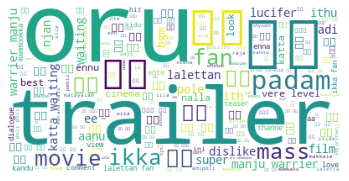

In [ ]:
text = " ".join(all_words_train)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

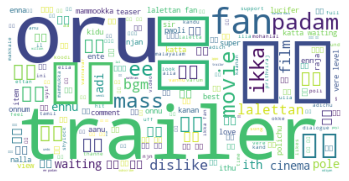

In [ ]:
text = " ".join(all_words_valid)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

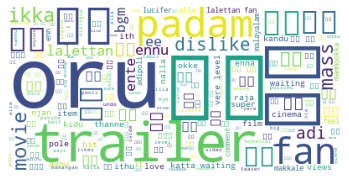

In [ ]:
text = " ".join(all_words_test)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
all_words = all_words_train + all_words_valid + all_words_test
corpus = train_text + valid_text + test_text
vocab_size = len(set(all_words)) # number of words to keep.
embedding_dim = 100 # Dimension of the vector representation for each word 
max_length = 0
for i in range(len(corpus)):
  x = word_tokenize(corpus[i])
  if len(x) > max_length:
    max_length = len(x)

oov_tok = "<OOV>"  # Token to represent Out-of-Vocabulary words

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [ ]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(train_text)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences,maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(valid_text)
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences,maxlen=max_length, padding='post')

train_padded = np.concatenate((training_padded, valid_padded), axis=0)

test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=max_length, padding='post')

In [ ]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [ ]:
filter_size = 128
kernel_size = 5
pool_size = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filter_size, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size, padding='same'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    #tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.8)]
    metrics=METRICS
)

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 186, 100)          3632000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 186, 128)          64128     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 38, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 165       
Total params: 3,739,589
Trainable params: 3,739,589
Non-trainable params: 0
___________________________________________

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

num_epochs = 100
history = model.fit(
    training_padded, 
    training_labels, 
    epochs=num_epochs, 
    batch_size = 32,
    callbacks=[callback],
    #validation_data=(valid_padded, validation_labels)
    validation_split=0.1,
    class_weight=class_weight
)

Epoch 1/100
451/451 [==============================] - 23s 44ms/step - loss: 7.5721 - accuracy: 0.8040 - precision: 0.5615 - recall: 0.0726 - auc: 0.7483 - val_loss: 1.3766 - val_accuracy: 0.7998 - val_precision: 0.4937 - val_recall: 0.0487 - val_auc: 0.8036
Epoch 2/100
451/451 [==============================] - 18s 41ms/step - loss: 5.5438 - accuracy: 0.8385 - precision: 0.7315 - recall: 0.3044 - auc: 0.8848 - val_loss: 1.1140 - val_accuracy: 0.8904 - val_precision: 0.8099 - val_recall: 0.5909 - val_auc: 0.8609
Epoch 3/100
451/451 [==============================] - 19s 41ms/step - loss: 4.5862 - accuracy: 0.8087 - precision: 0.5509 - recall: 0.2361 - auc: 0.8597 - val_loss: 1.0386 - val_accuracy: 0.8284 - val_precision: 0.7539 - val_recall: 0.2105 - val_auc: 0.8999
Epoch 4/100
451/451 [==============================] - 18s 41ms/step - loss: 4.7044 - accuracy: 0.8582 - precision: 0.7572 - recall: 0.4308 - auc: 0.9050 - val_loss: 1.5697 - val_accuracy: 0.7929 - val_precision: 0.4007 - v

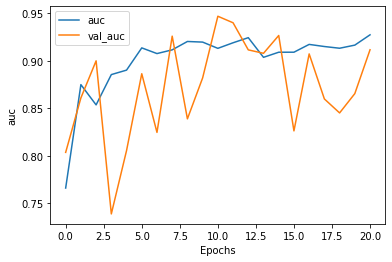

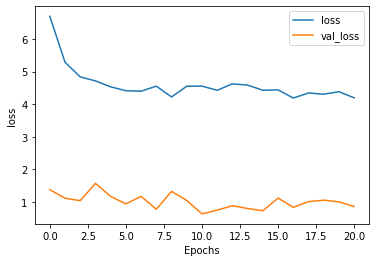

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc")
plot_graphs(history, "loss")

In [ ]:
score = model.evaluate(valid_padded, validation_labels)
print("Loss = {}".format(score[0]))
print("Accuracy = {0:.2f}%".format(score[1]*100))

63/63 [==============================] - 0s 4ms/step - loss: 0.3007 - accuracy: 0.9709 - precision: 0.9335 - recall: 0.9200 - auc: 0.9871
Loss = 0.3007238209247589
Accuracy = 97.09%


In [ ]:
y_pred = model.predict_classes(valid_padded)

accuracy = accuracy_score(valid_label, y_pred)
precision = precision_score(valid_label, y_pred, average='macro')
recall = recall_score(valid_label, y_pred, average='macro')
f1 = f1_score(valid_label, y_pred, average='macro')

print("Accuracy = {0:.2f}".format(accuracy*100))
print("Precision = {0:.4f}".format(precision))
print("Recall = {0:.4f}".format(recall))
print("F1-score = {0:.4f}".format(f1))

Accuracy = 92.90
Precision = 0.6310
Recall = 0.6558
F1-score = 0.6308


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# Write some new reviews 

review1 = "ഈ കിളവന് നിർത്താറായില്ലേ കല്യാണം കഴിക്കാൻ നടക്കൽ..."
review2 = "I like mohanlal sirrr love from tamilnaduu"
review3 = "From tamilnadu mamukka fan vera level"

review1 = preprocess_data(review1)
review2 = preprocess_data(review2)
review3 = preprocess_data(review3)

new_reviews = [review1, review2, review3]

In [ ]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews           

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict_classes(reviews_padded)
  classes_prob = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(le.inverse_transform([classes[x]]))
    print(classes_prob[x])
    print('\n')

predict_review(model, new_reviews)

ഈ കിളവന് നിർത്താറായില്ലേ കല്യാണം കഴിക്കാൻ നടക്കൽ
['Offensive_Targeted_Insult_Individual']
[0.13618976 0.37248576 0.4631635  0.02561303 0.002548  ]


i like mohanlal sirrr love from tamilnaduu
['not-malayalam']
[1.6731882e-03 8.7007979e-10 4.0976922e-10 5.6401204e-09 9.9832684e-01]


from tamilnadu mamukka fan vera level
['not-malayalam']
[8.5396476e-02 1.0122572e-09 3.3802166e-09 4.0519780e-08 9.1460353e-01]




/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
classes = model.predict_classes(test_padded)
pred = []

for i in range(len(classes)):
  pred.append(le.inverse_transform([classes[i]])[0])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
pred[0:7]

['not-malayalam',
 'Offensive_Targeted_Insult_Individual',
 'Offensive_Targeted_Insult_Individual',
 'Offensive_Untargetede',
 'Not_offensive',
 'Not_offensive',
 'Not_offensive']